<a href="https://colab.research.google.com/github/ArinaYuhimenko/ML/blob/main/Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Классификация изображений Нейронными сетями**

## Импортируем

Понизим TensorFlow до версии 2.8.3

In [118]:
pip install tensorflow==2.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.5/498.5 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 110.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 61.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully unins

In [119]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Загружаем набор данных - цветы

In [120]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [121]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Посмотрим несколько цветов

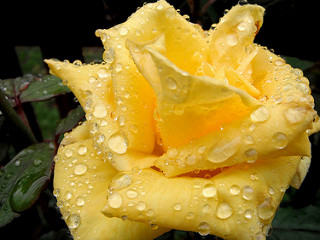

In [122]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[9]))

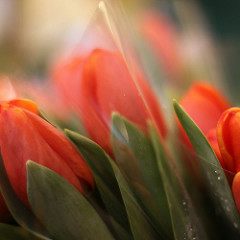

In [123]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[28]))

In [124]:
batch_size = 32
img_height = 180
img_width = 180
IMG_SIZE = (180, 180)

Поделим на выборки

In [125]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [126]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Представлено 5 классов

In [127]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Визуализация Batch

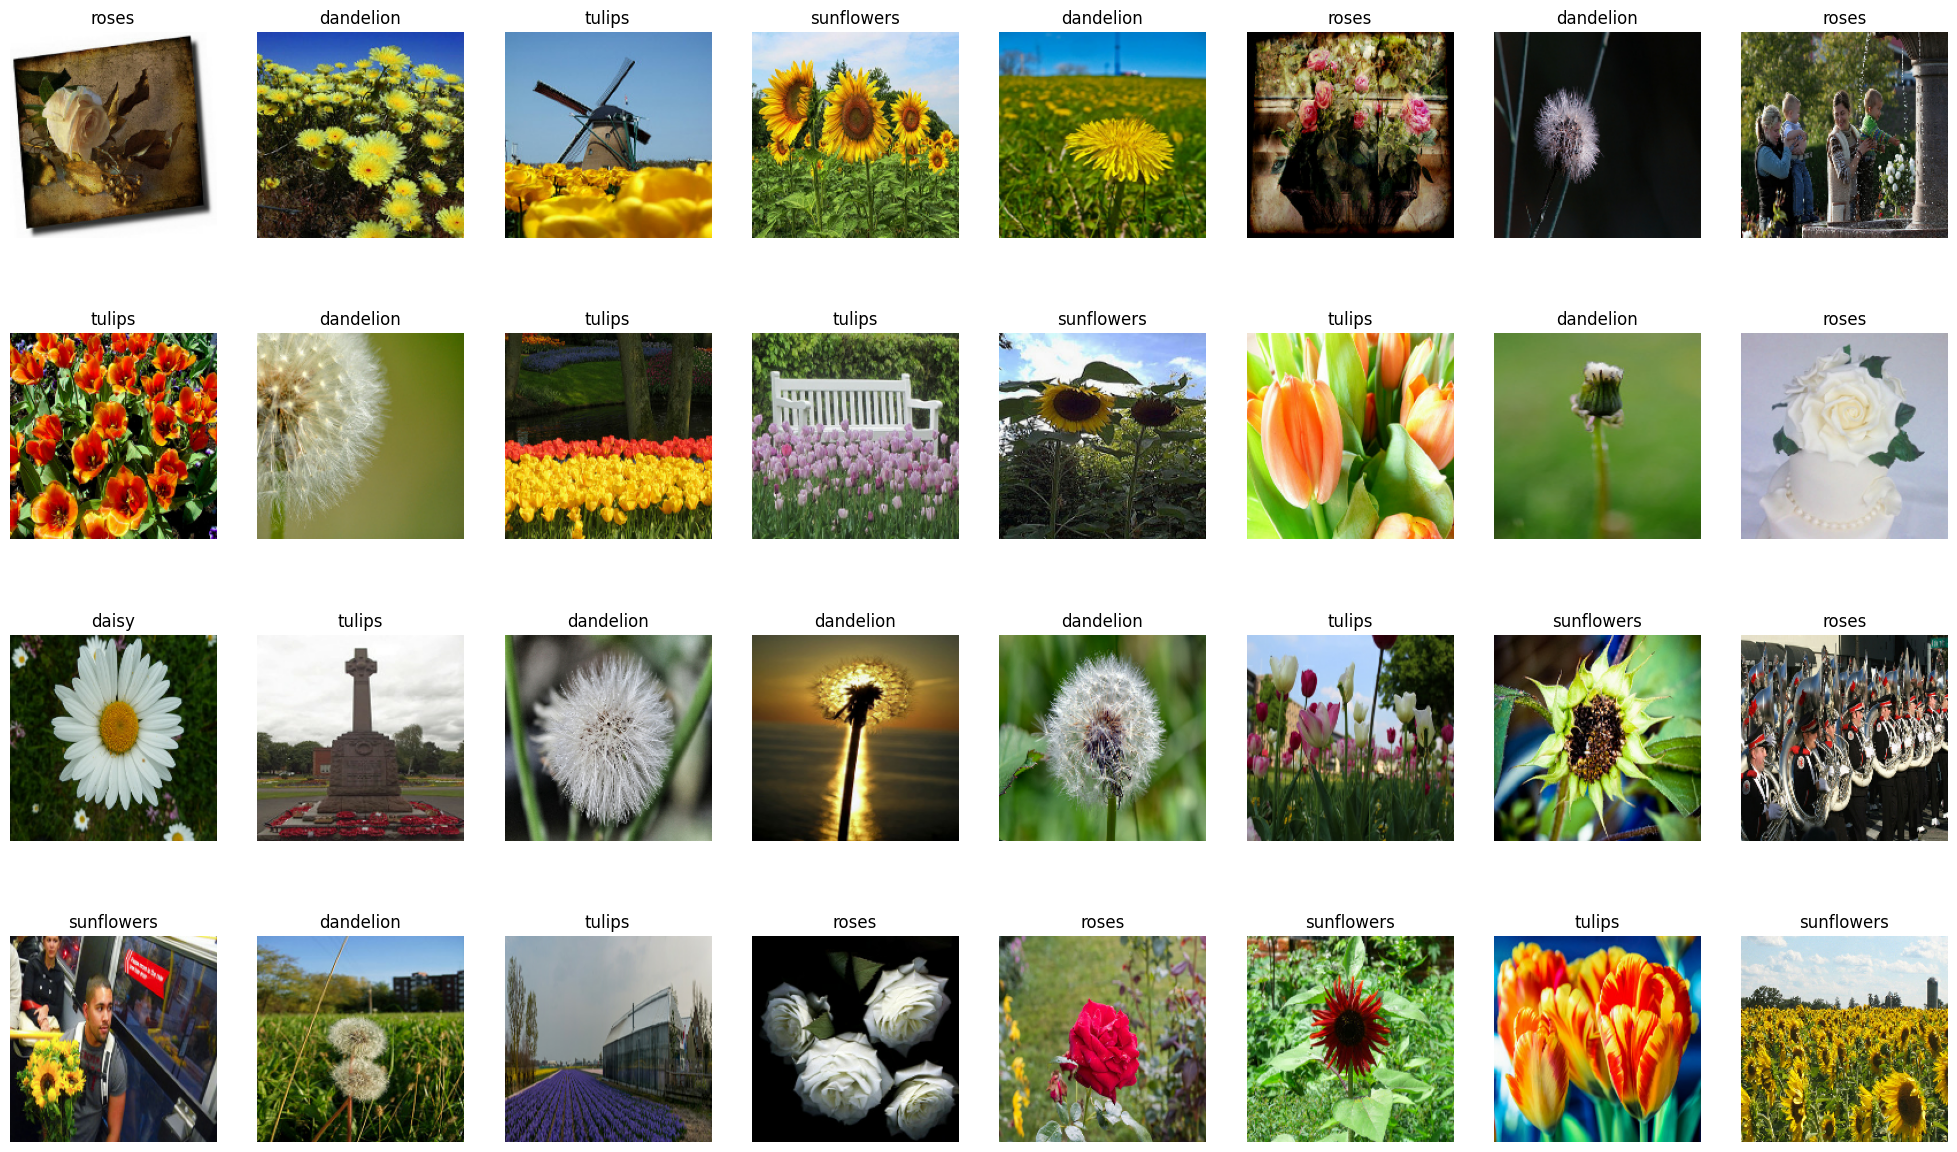

In [128]:
plt.figure(figsize=(25, 15))
for images, labels in train_ds.take(1):
  for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

image_b -  тензор формы (32, 180, 180, 3)

In [129]:
for image_b, labels_b in train_ds:
  print(image_b.shape)
  print(labels_b.shape)
  break

(32, 180, 180, 3)
(32,)


## Создание слоя для Data Augmentation

In [130]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Визуализируем изображение

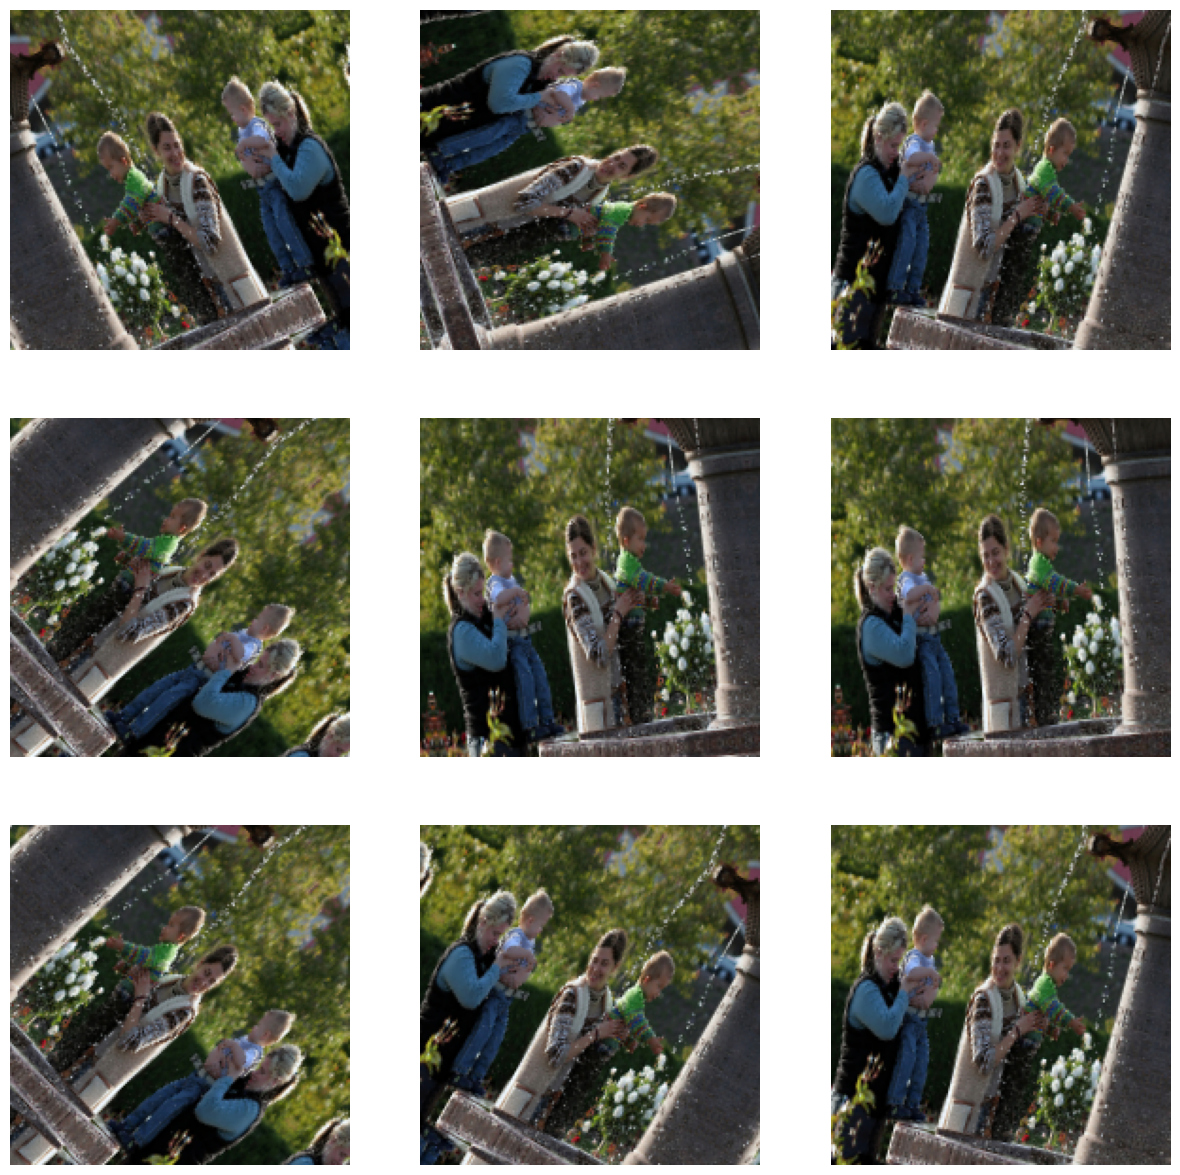

In [131]:
index  = 7
image=tf.expand_dims(images[index], 0)

fig = plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(image)

    plt.imshow(tf.reshape(augmented_image, images[i].shape).numpy().astype("uint8"))

    plt.axis("off")

## Загрузка модели MobileNet с весами и прочим
* Помещаем модель в переменную base_model

In [132]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

## Краткое изложение модели

In [133]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

## Создание слоя для предварительной обработки

In [134]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

До предобработки

In [135]:
image

<tf.Tensor: shape=(1, 180, 180, 3), dtype=float32, numpy=
array([[[[135.87222   , 139.9861    , 101.96389   ],
         [ 80.2       ,  86.60834   ,  53.808334  ],
         [107.12221   , 103.84721   ,  40.43333   ],
         ...,
         [ 34.977818  ,  30.019506  ,  21.338943  ],
         [ 35.81675   ,  27.666748  ,  19.858438  ],
         [ 34.430664  ,  28.944494  ,  19.305622  ]],

        [[121.56111   , 117.33611   ,  72.37222   ],
         [ 83.63333   ,  88.28333   ,  43.925     ],
         [121.622215  , 124.944435  ,  43.252777  ],
         ...,
         [ 35.661148  ,  32.89446   ,  21.583368  ],
         [ 36.666626  ,  33.966637  ,  23.81654   ],
         [ 32.316875  ,  30.383484  ,  23.027948  ]],

        [[123.90279   , 123.26389   ,  66.75      ],
         [115.25      , 117.25      ,  51.041668  ],
         [ 99.31944   , 106.02777   ,  41.40278   ],
         ...,
         [ 35.125     ,  31.569458  ,  22.680573  ],
         [ 37.33338   ,  31.791626  ,  23.416649

После

In [136]:
preprocess_input(image)

<tf.Tensor: shape=(1, 180, 180, 3), dtype=float32, numpy=
array([[[[ 0.06566453,  0.09793019, -0.20028323],
         [-0.37098044, -0.32071894, -0.57797384],
         [-0.1598258 , -0.18551207, -0.6828759 ],
         ...,
         [-0.72566414, -0.7645529 , -0.83263576],
         [-0.7190843 , -0.7830059 , -0.8442475 ],
         [-0.72995555, -0.7729844 , -0.84858334]],

        [[-0.04657954, -0.07971674, -0.43237472],
         [-0.3440523 , -0.30758172, -0.65549016],
         [-0.04610026, -0.02004367, -0.66076255],
         ...,
         [-0.7203047 , -0.7420043 , -0.8307187 ],
         [-0.7124186 , -0.733595  , -0.8132036 ],
         [-0.74653435, -0.7616982 , -0.8193886 ]],

        [[-0.02821344, -0.03322434, -0.4764706 ],
         [-0.09607846, -0.08039218, -0.59967315],
         [-0.22102398, -0.16840965, -0.67527235],
         ...,
         [-0.72450984, -0.7523964 , -0.82211316],
         [-0.7071892 , -0.7506539 , -0.81634   ],
         [-0.75217766, -0.77570707, -0.832352 

## Feedforward для одной batch

In [137]:
image_b, label_b = next(iter(train_ds))
feature_batch = base_model(image_b)
print(feature_batch.shape)

(32, 6, 6, 1280)


Размерность результата:
* 32 изображений в batch
* 5x5 размерность последнего сверточного слоя mobilenet
* 1280 количество сверточных фильтров на последнем слое

## Создание слоя усреднения

In [138]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


## Создание последнего полносвязного слоя для прогнозирования

In [139]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


## Собираем модель

In [140]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Компилируем модель
* Оптимизатор tf.keras.optimizers.Adam и функция потерь tf.keras.losses.SparseCategoricalCrossentropy 

In [141]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

## Обучаем модель

In [142]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 85s 913ms/step - loss: 1.3246 - accuracy: 0.4353 - val_loss: 1.0993 - val_accuracy: 0.5804
Epoch 2/10
92/92 [==============================] - 78s 844ms/step - loss: 0.9884 - accuracy: 0.6066 - val_loss: 0.9687 - val_accuracy: 0.6240
Epoch 3/10
92/92 [==============================] - 78s 844ms/step - loss: 0.7806 - accuracy: 0.7091 - val_loss: 0.9256 - val_accuracy: 0.6308
Epoch 4/10
92/92 [==============================] - 84s 907ms/step - loss: 0.5528 - accuracy: 0.7987 - val_loss: 1.1395 - val_accuracy: 0.5845
Epoch 5/10
92/92 [==============================] - 85s 926ms/step - loss: 0.3465 - accuracy: 0.8828 - val_loss: 1.1460 - val_accuracy: 0.6308
Epoch 6/10
92/92 [==============================] - 79s 852ms/step - loss: 0.1882 - accuracy: 0.9414 - val_loss: 1.3430 - val_accuracy: 0.6485
Epoch 7/10
92/92 [==============================] - 83s 898ms/step - loss: 0.1319 - accuracy: 0.9625 - val_loss: 1.6041 - val_accuracy: 0.6267

## Построение текущих результатов

Text(0.5, 0, 'эпоха')

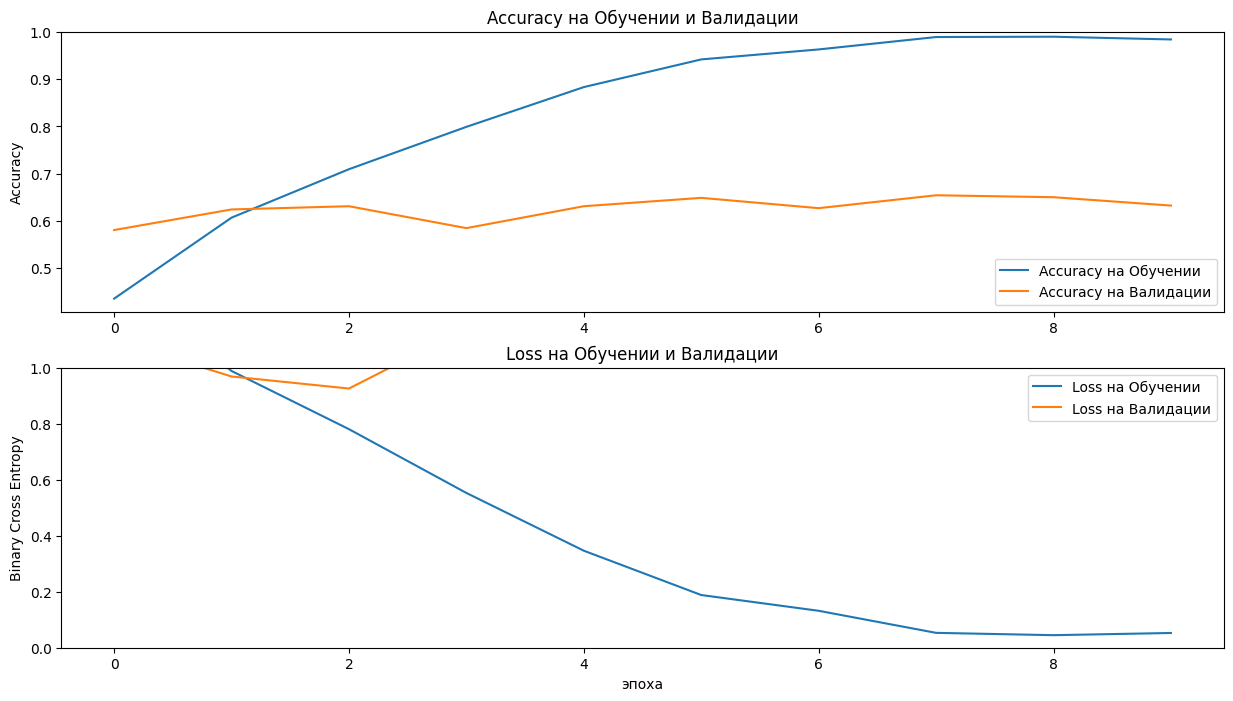

In [143]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Accuracy на Обучении')
plt.plot(val_acc, label='Accuracy на Валидации')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy на Обучении и Валидации')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Loss на Обучении')
plt.plot(val_loss, label='Loss на Валидации')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,1.0])
plt.title('Loss на Обучении и Валидации')
plt.xlabel('эпоха')

Графики показывают, что модель достигла только около 65% точности на проверочном наборе

## Fine-Tune 

In [144]:
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  154


In [145]:
base_model.trainable = True

# Fine-tune от этого слоя и далее
fine_tune_at = 140

# Заморозим все слои перед слоем `fine_tune_at`
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [151]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Компилируем снова

In [152]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [155]:
input_shape = (None, 180, 180, 3)
model.build(input_shape)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

In [156]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 87s 926ms/step - loss: 1.4514 - accuracy: 0.3825 - val_loss: 1.1551 - val_accuracy: 0.5204
Epoch 2/15
92/92 [==============================] - 97s 1s/step - loss: 1.1093 - accuracy: 0.5473 - val_loss: 1.0162 - val_accuracy: 0.5763
Epoch 3/15
92/92 [==============================] - 91s 991ms/step - loss: 1.0037 - accuracy: 0.5978 - val_loss: 0.9516 - val_accuracy: 0.6199
Epoch 4/15
92/92 [==============================] - 92s 998ms/step - loss: 0.9470 - accuracy: 0.6182 - val_loss: 0.8829 - val_accuracy: 0.6553
Epoch 5/15
92/92 [==============================] - 87s 947ms/step - loss: 0.8908 - accuracy: 0.6492 - val_loss: 0.9102 - val_accuracy: 0.6471
Epoch 6/15
92/92 [==============================] - 90s 972ms/step - loss: 0.8563 - accuracy: 0.6689 - val_loss: 0.8758 - val_accuracy: 0.6553
Epoch 7/15
92/92 [==============================] - 86s 932ms/step - loss: 0.7999 - accuracy: 0.6928 - val_loss: 0.8299 - val_accuracy: 0.6662
Ep

## Визуализируем снова

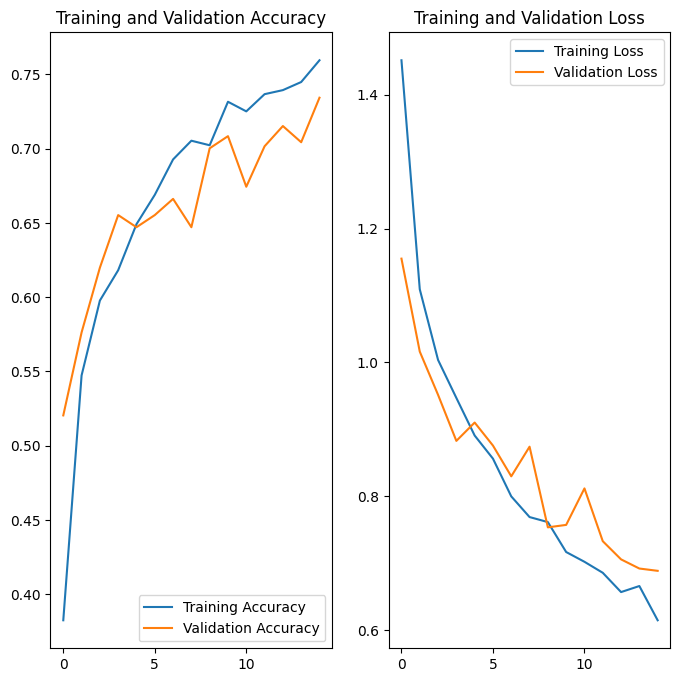

In [157]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Предсказываем новые данные

In [158]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

In [181]:
sunflower_path = '/content/oduvan.jpeg'
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(class_names[np.argmax(score)])

1/1 [==============================] - 0s 33ms/step
dandelion


In [182]:
sunflower_path = '/content/oduvan1.jpg'
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(class_names[np.argmax(score)])

1/1 [==============================] - 0s 43ms/step
dandelion


In [183]:
sunflower_path = '/content/oduvan2.jpg'
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(class_names[np.argmax(score)])

1/1 [==============================] - 0s 29ms/step
dandelion


In [184]:
sunflower_path = '/content/pods1.jpg'
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(class_names[np.argmax(score)])

1/1 [==============================] - 0s 26ms/step
sunflowers


In [185]:
sunflower_path = '/content/pods2.jpg'
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(class_names[np.argmax(score)])

1/1 [==============================] - 0s 28ms/step
sunflowers


In [186]:
sunflower_path = '/content/roz.jpg'
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(class_names[np.argmax(score)])

1/1 [==============================] - 0s 27ms/step
roses


In [187]:
sunflower_path = '/content/roz2.jpg'
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(class_names[np.argmax(score)])

1/1 [==============================] - 0s 31ms/step
roses


In [188]:
sunflower_path = '/content/roz3.jpg'
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(class_names[np.argmax(score)])

1/1 [==============================] - 0s 27ms/step
roses


In [189]:
sunflower_path = '/content/tulpan.jpeg'
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(class_names[np.argmax(score)])

1/1 [==============================] - 0s 42ms/step
tulips


In [190]:
sunflower_path = '/content/tulpans.jpg'
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(class_names[np.argmax(score)])

1/1 [==============================] - 0s 43ms/step
tulips
